In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from models import glow
from flows.glow import resnet_glow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
batch_size = 1
#X_train = np.expand_dims(X_train, axis=-1)
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
X_train_ds = X_train_ds.map(lambda x: x / 255.).shuffle(buffer_size=1000).batch(batch_size)

In [3]:
#n_vars = np.prod(X_train.shape[1:])
#normal_diag = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros((1,n_vars,)), scale_diag=tf.ones((1,n_vars,)))
#reshape = tfp.bijectors.Reshape(X_train.shape[1:])
#prior = reshape(normal_diag)
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros((1, *X_train.shape[1:])), scale_diag=tf.ones((1, *X_train.shape[1:])))
model = glow.Glow(prior, num_layers=1, depth_per_layer=4, coupling_nn_ctor=resnet_glow(hidden_dims=64),
                  optimizer=tf.keras.optimizers.Adamax(lr=1.0E-5))

In [5]:
from tqdm import tqdm
N = 1000
with tqdm(total=N) as prog:
    loss_hist = []
    nll_hist = []
    for batch in X_train_ds.take(N):
        loss, nll, ildj = model.train_batch(batch)
        loss_hist.append(loss.numpy())
        nll_hist.append(nll.numpy())
        prog.update(batch_size)
        prog.set_postfix({'loss': np.mean(loss_hist), 'nll': np.mean(nll_hist), 'ildj': ildj.numpy()})

  1%|          | 8/1000 [00:05<10:51,  1.52it/s, loss=2.92e+3, nll=403, ildj=3.34e+3]     


KeyboardInterrupt: 

In [6]:
x = model.target_dist.sample()
print(x)
print(tf.math.reduce_mean(model.target_dist.log_prob(x)))
_ = tf.debugging.assert_all_finite(x, 'found nan or inf values')

tf.Tensor(
[[[[ 5.89225280e+08 -5.90814528e+08  2.21058586e+09]
   [-5.91018176e+08 -5.80128128e+08 -6.54930074e+09]
   [ 9.85599936e+08 -9.88001152e+08 -5.44402432e+09]
   ...
   [-1.31214771e+09 -1.28863846e+09 -2.18876805e+10]
   [ 8.43701568e+08 -8.46790656e+08 -6.92118464e+08]
   [-8.45901888e+08 -8.31268608e+08 -6.58429440e+09]]

  [[-5.86430784e+08  1.79562125e+09  7.68776806e+09]
   [-5.92384128e+08 -1.86721649e+10 -6.14576384e+09]
   [-9.82556800e+08 -5.72592845e+09  7.08648704e+09]
   ...
   [-1.31634893e+09  4.45146112e+10  1.85266319e+10]
   [-8.40407936e+08 -3.04728576e+09 -4.56330957e+09]
   [-8.48576448e+08 -6.01604416e+08  3.39105101e+09]]

  [[ 9.66584192e+08 -9.68465920e+08  5.22327808e+08]
   [-9.68890048e+08 -9.51975168e+08 -5.88122061e+09]
   [ 1.66743949e+09 -1.67205248e+09 -2.30605312e+09]
   ...
   [-2.36443878e+09 -2.32288000e+09 -6.15232922e+09]
   [ 1.47505869e+09 -1.47989478e+09 -6.03938150e+09]
   [-1.48044621e+09 -1.45483277e+09 -2.07868744e+10]]

  ...

 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


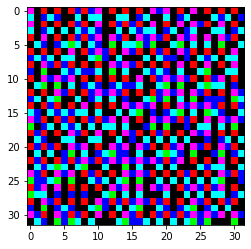

In [7]:
import matplotlib.pyplot as plt
plt.imshow(tf.squeeze(x))